In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import skew
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import lightgbm as lgb

/Users/kuariby/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_9.4.1) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
#データの読み込み
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
#外れ値の処理
df_train = df_train[~((df_train['GrLivArea'] > 4000) & (df_train['SalePrice'] < 300000))]
#Id及びSaleprice以外の全データを結合(左端=Id, 右端はSalePrice)
df_all = pd.concat((df_train.loc[:,'MSSubClass':'SaleCondition'], df_test.loc[:,'MSSubClass':'SaleCondition']))
#Feature Engineering - 前回の中で断トツでFeature Importanceが高かったTotalHousePorchSFを採用
df_all['TotalHousePorchSF'] = df_all['EnclosedPorch']+df_all['OpenPorchSF']+df_all['WoodDeckSF']+df_all['3SsnPorch']+df_all['ScreenPorch']
df_train['TotalHousePorchSF'] = df_train['EnclosedPorch']+df_train['OpenPorchSF']+df_train['WoodDeckSF']+df_train['3SsnPorch']+df_train['ScreenPorch']

df_all['TotalFinSF'] = df_all['1stFlrSF']+df_all['2ndFlrSF']
df_train['TotalFinSF'] = df_train['1stFlrSF']+df_train['2ndFlrSF']

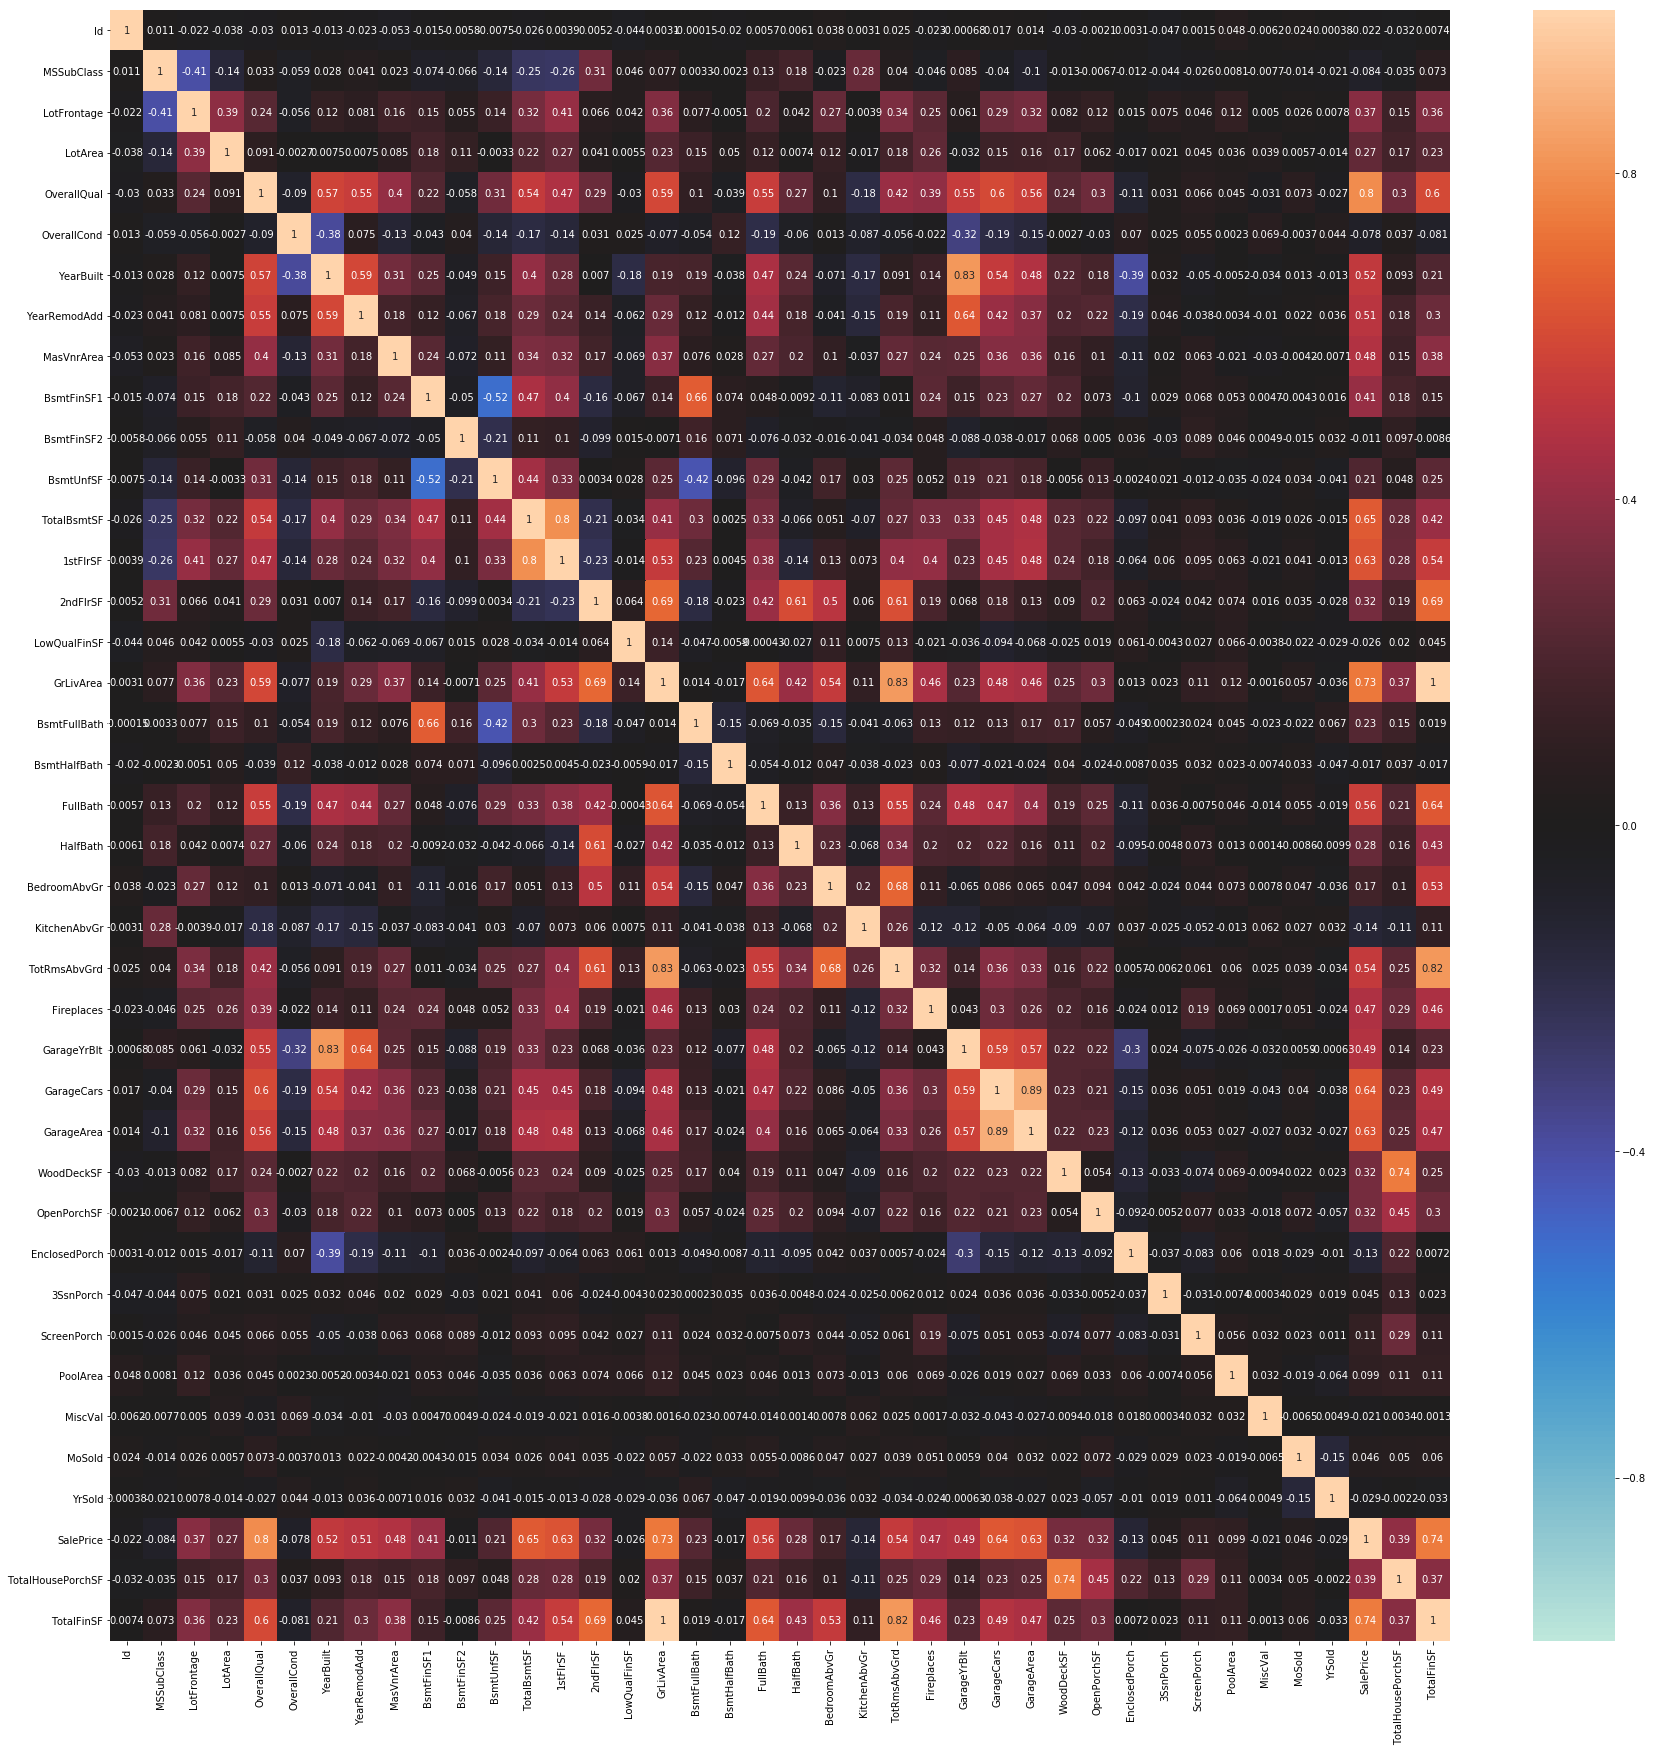

In [3]:
#相関係数行列の可視化
fig, ax = plt.subplots(1, 1, figsize=(30, 30))
sns.heatmap(df_train.corr(), vmax=1, vmin=-1, center=0, annot=True, ax=ax)

In [4]:
df_all.drop(['1stFlrSF','GarageArea','TotRmsAbvGrd', 'GarageYrBlt'], axis=1, inplace=True)

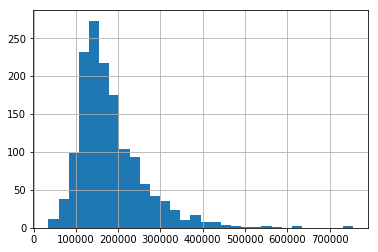

In [5]:
df_train["SalePrice"].hist(bins=30)

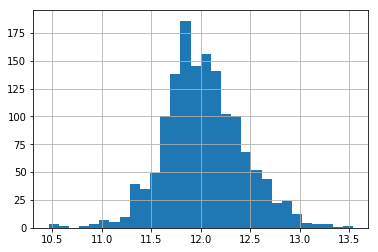

In [6]:
df_train["SalePrice"] = np.log1p(df_train["SalePrice"])
#対数変換後の分布を確認
df_train["SalePrice"].hist(bins=30)

In [7]:
#カテゴリカルでない特徴量
non_categoricals = df_all.dtypes[df_all.dtypes != "object"].index
skewed_feats = df_train[non_categoricals].apply(lambda x: skew(x.dropna()))
skewed_feats = skewed_feats[skewed_feats > 0.6].index
#歪度0.7より大きい特徴量を対数変換
df_all[skewed_feats] = np.log1p(df_all[skewed_feats])

In [8]:
#One Hot Encoding
df_all = pd.get_dummies(df_all)
#欠損値を平均値で補完
df_all = df_all.fillna(df_all.mean())

In [9]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

In [10]:
df_train.shape[0]

1458

In [11]:
#学習データ、テストデータに分割
X = df_all[:df_train.shape[0]]# == train = all_data[:ntrain]
X_for_test = df_all[df_train.shape[0]:] # == test = all_data[ntrain:]
y = df_train.SalePrice # == y_train
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1111)

In [12]:
#reg = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
#reg.fit(X, y)

In [13]:
#y_pred = reg.predict(X_test)
#print("ラッソ回帰でのRMSE:",np.sqrt(mean_squared_error(y_pred, y_test)))

In [14]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))

In [15]:
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))

In [16]:
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)

In [17]:
lgb_train = lgb.Dataset(X_train,y_train)

In [18]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

In [19]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

In [20]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [21]:
#Validation function


def rmsle_cv(model):
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    score = np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=cv))
   # rmse= np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv = kf))
    return(score)

In [22]:
def rmsle_cv_(model):
    model.fit(X, y)
    y_train_pred = model.predict(X)
    rmse = np.sqrt(mean_squared_error(y, y_train_pred))
    return(rmse)

In [23]:
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

/Users/kuariby/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)



Lasso score: 0.1104 (0.0072)



In [24]:
score = rmsle_cv(ENet)
print("ElasticNet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

/Users/kuariby/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


ElasticNet score: 0.1104 (0.0072)



In [25]:
#params = {'task': 'train','boosting_type': 'gbdt','objective': 'regression','metric': {'l2'},'num_leaves': 256,
#'learning_rate': 0.01,'num_iterations':2000,'feature_fraction': 0.4,'bagging_fraction': 0.7,'bagging_freq': 5}
#gbm = lgb.train(params, lgb_train, num_boost_round=1500)
#y_test_pred_lgb = gbm.predict(np.array(X_test), num_iteration=gbm.best_iteration)
#RMSE
#print("LightGBMでのRMSE:",np.sqrt(mean_squared_error(y_test, y_test_pred_lgb)))

In [26]:
score = rmsle_cv(model_lgb)
print("LGBM score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))

LGBM score: 0.1152 (0.0084)



In [71]:
score = rmsle_cv(KRR)
print("Kernel Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Kernel Ridge score: 0.1585 (0.0138)



In [28]:
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.1162 (0.0099)



In [29]:
score = rmsle_cv(model_xgb)
print("Xgboost score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Xgboost score: 0.1163 (0.0086)



In [30]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)   

In [95]:
averaged_models = AveragingModels(models = (ENet, lasso, model_xgb, model_lgb, GBoost))

score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

/Users/kuariby/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
/Users/kuariby/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


 Averaged base models score: 0.1083 (0.0081)



In [69]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                print(train_index)
                print(holdout_index)
                instance.fit(pd.DataFrame(X).values, pd.Series(y))
                y_pred = instance.predict(X)
                out_of_fold_predictions[:, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [70]:
stacked_averaged_models = StackingAveragedModels(base_models = (ENet, GBoost, KRR),
                                                 meta_model = lasso)

score = rmsle_cv_(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

[   0    1    2 ... 1455 1456 1457]
[   8   20   21   23   28   29   32   34   37   38   39   42   47   50
   69   71   75   85   88   89   96   97  103  108  109  111  113  117
  121  132  145  146  149  166  174  194  196  198  202  207  208  213
  218  223  226  233  235  239  242  243  249  253  258  269  282  284
  287  293  301  306  318  319  323  325  328  329  336  342  349  356
  357  372  376  380  382  389  401  406  407  408  414  418  422  435
  444  452  465  470  477  481  484  486  487  490  493  494  507  517
  518  522  531  538  540  544  556  561  572  577  578  580  583  591
  594  595  601  602  605  611  616  619  622  628  629  633  638  645
  650  658  660  668  678  690  692  705  717  722  726  736  738  740
  757  766  773  774  776  782  785  787  797  799  805  814  816  822
  823  829  831  832  836  845  848  851  858  872  873  877  894  895
  899  903  906  939  942  947  950  959  963  964  965  966  969  974
  980  988  991  995 1000 1002 1003 1005 

[   0    1    2 ... 1455 1456 1457]
[  12   16   17   22   31   35   44   52   53   56   57   58   62   77
   78   79   81   91   93  102  105  110  112  114  125  135  136  137
  140  150  152  153  167  171  173  175  176  180  183  185  191  193
  197  200  204  205  206  212  215  217  221  227  228  229  237  241
  245  254  257  259  260  263  266  271  273  286  289  290  291  294
  295  300  305  309  310  312  313  321  331  337  347  353  355  358
  362  364  367  371  375  379  383  386  391  393  402  410  419  426
  430  433  436  442  443  448  451  455  457  467  469  474  495  498
  509  511  512  513  521  524  527  550  553  555  568  573  579  581
  582  588  590  600  606  625  632  636  643  649  652  656  662  666
  670  672  673  674  680  683  694  695  696  700  703  704  708  709
  714  718  724  739  743  747  748  754  761  762  768  771  775  779
  783  789  791  795  798  801  802  807  830  841  843  846  850  853
  855  859  861  862  865  870  874  876 

[   0    1    5 ... 1453 1455 1457]
[   2    3    4    6   10   13   30   33   40   46   49   54   63   80
   92   98   99  106  107  123  129  131  134  139  141  143  147  155
  157  159  160  162  163  164  172  179  182  186  189  192  199  209
  210  224  231  232  236  252  255  262  265  270  274  298  299  320
  324  326  330  333  338  345  348  352  359  361  363  366  377  390
  392  395  400  403  404  405  409  411  412  413  415  416  420  424
  427  429  438  439  441  445  453  456  460  471  472  476  488  497
  499  500  502  504  510  514  515  520  523  530  532  539  546  547
  549  558  559  564  565  571  584  585  586  587  593  598  603  624
  627  631  634  637  640  644  646  653  657  671  679  681  682  688
  691  693  701  721  723  725  727  728  729  730  733  741  746  750
  751  752  753  756  758  763  765  770  777  780  794  800  806  810
  817  819  820  824  826  833  834  837  852  854  869  871  878  880
  882  884  892  896  897  905  917  918 

In [ ]:
#print("LightGBM+Lassoのスタッキング時のRMSE:",np.sqrt(mean_squared_error(y_test, (y_pred*0.7+y_test_pred_lgb*0.3))))

In [75]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [76]:
stacked_averaged_models.fit(X, y)
stacked_train_pred = stacked_averaged_models.predict(X)
stacked_pred = np.expm1(stacked_averaged_models.predict(X_for_test))
print(rmsle(y, stacked_train_pred))

[   0    1    2 ... 1455 1456 1457]
[   8   20   21   23   28   29   32   34   37   38   39   42   47   50
   69   71   75   85   88   89   96   97  103  108  109  111  113  117
  121  132  145  146  149  166  174  194  196  198  202  207  208  213
  218  223  226  233  235  239  242  243  249  253  258  269  282  284
  287  293  301  306  318  319  323  325  328  329  336  342  349  356
  357  372  376  380  382  389  401  406  407  408  414  418  422  435
  444  452  465  470  477  481  484  486  487  490  493  494  507  517
  518  522  531  538  540  544  556  561  572  577  578  580  583  591
  594  595  601  602  605  611  616  619  622  628  629  633  638  645
  650  658  660  668  678  690  692  705  717  722  726  736  738  740
  757  766  773  774  776  782  785  787  797  799  805  814  816  822
  823  829  831  832  836  845  848  851  858  872  873  877  894  895
  899  903  906  939  942  947  950  959  963  964  965  966  969  974
  980  988  991  995 1000 1002 1003 1005 

[   0    1    2 ... 1455 1456 1457]
[  12   16   17   22   31   35   44   52   53   56   57   58   62   77
   78   79   81   91   93  102  105  110  112  114  125  135  136  137
  140  150  152  153  167  171  173  175  176  180  183  185  191  193
  197  200  204  205  206  212  215  217  221  227  228  229  237  241
  245  254  257  259  260  263  266  271  273  286  289  290  291  294
  295  300  305  309  310  312  313  321  331  337  347  353  355  358
  362  364  367  371  375  379  383  386  391  393  402  410  419  426
  430  433  436  442  443  448  451  455  457  467  469  474  495  498
  509  511  512  513  521  524  527  550  553  555  568  573  579  581
  582  588  590  600  606  625  632  636  643  649  652  656  662  666
  670  672  673  674  680  683  694  695  696  700  703  704  708  709
  714  718  724  739  743  747  748  754  761  762  768  771  775  779
  783  789  791  795  798  801  802  807  830  841  843  846  850  853
  855  859  861  862  865  870  874  876 

[   1    2    3 ... 1454 1455 1456]
[   0    9   15   19   24   25   41   43   45   48   59   60   64   65
   68   70   72   73   82   83   84   86   90   94   95  100  115  116
  120  127  128  130  142  148  154  156  177  178  187  188  195  201
  203  214  216  220  222  230  234  238  240  250  256  264  267  268
  275  277  278  292  297  302  304  307  311  315  327  332  334  340
  346  350  368  369  370  378  381  384  387  388  394  434  437  450
  454  458  459  462  463  464  473  475  479  482  489  491  501  503
  506  508  519  525  526  534  535  537  541  542  543  548  551  562
  563  575  576  589  597  599  604  609  612  617  618  630  635  641
  647  654  655  664  665  675  676  684  685  699  706  707  710  712
  713  720  732  734  735  745  749  759  764  772  778  781  786  792
  796  804  813  818  821  828  835  838  839  842  844  847  857  860
  863  864  866  867  868  879  883  887  901  904  909  919  921  925
  927  929  931  935  938  940  945  948 

In [ ]:
#全データで学習
reg.fit(X, y)
lgb_train_full = lgb.Dataset(X,y)
gbm = lgb.train(params, lgb_train_full, num_boost_round=1500)

In [77]:
model_xgb.fit(X, y)
xgb_train_pred = model_xgb.predict(X)
xgb_pred = np.expm1(model_xgb.predict(X_for_test))
print(rmsle(y, xgb_train_pred))

0.08213412837359081


In [80]:
model_lgb.fit(X, y)
lgb_train_pred = model_lgb.predict(X)
lgb_pred = np.expm1(model_lgb.predict(X_for_test))
print(rmsle(y, lgb_train_pred))

0.07330465625407341


In [81]:
print('RMSLE score on train data:')
print(rmsle(y,stacked_train_pred*0.70 +
               xgb_train_pred*0.15 + lgb_train_pred*0.15 ))

RMSLE score on train data:
0.051039166136344925


In [85]:
ensemble = stacked_pred*0.40 + xgb_pred*0.30 + lgb_pred*0.30

In [79]:
#ラッソ・LightGBMの予測及びスタッキング
pred = np.expm1(reg.predict(X_for_test))
pred2 = np.expm1(gbm.predict(X_for_test))
pred3 = (pred*0.7+pred2*0.3)

NameError: name 'reg' is not defined

In [96]:
averaged_models.fit(X, y)
pred4 = np.expm1(averaged_models.predict(X_for_test))

In [ ]:
solution = pd.DataFrame({"id":df_test.Id, "SalePrice":pred3})
solution.to_csv("sample3.csv", index = False)

In [97]:
solution = pd.DataFrame({"id":df_test.Id, "SalePrice":pred4})
solution.to_csv("submission.csv", index = False)

In [ ]:
y.loc[1457,:]

In [ ]:
train_index

In [39]:
X.columns[np.isinf(X).any()]

Index([], dtype='object')

In [40]:
np.isinf(y).any()

False

In [44]:
print(X[train_index].class)
print(y[train_index].class)

SyntaxError: invalid syntax (<ipython-input-44-89ffa11c63a9>, line 1)

In [48]:
X.dtypes()

TypeError: 'Series' object is not callable